In [2]:
import os
import errno

import io
import json
import os
import re
import tarfile
import tempfile

import traceback
import json

import numpy as np

import deepcell
import matplotlib.pyplot as plt

from deepcell.datasets.tracked import hek293,nih_3t3_bench,nih_3t3,hek293_bench,hela_s3_bench,raw2647_bench
from deepcell.datasets.cytoplasm import hela,nih_3t3,cho
from PIL import Image
import imageio
import cv2
import random

import imgaug.augmenters as iaa

import torch
import torchvision.transforms.functional as TF

#from skimage import io
import tifffile as tiff

from sklearn.cluster import KMeans

from skimage.transform import resize
import pandas as pd

from skimage.io import imread

from deepcell_tracking.trk_io import load_trks
from scipy.spatial import KDTree

2023-08-16 14:36:54.225035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/cv2/../../../../lib:
2023-08-16 14:36:54.225063: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [8]:
def gt_to_pos(track):
    
    plt.imshow(track[8].squeeze(), cmap='gray')
    plt.colorbar()
    plt.show()
    
    
    resized_tensor = np.zeros((track.shape[0], 150, 150, 1))

    for i in range(track.shape[0]):
        #print(i)
        resized_tensor[i,:,:,0] = resize(track[i,:,:,0], (150, 150))

    track_res = (resized_tensor/np.max(resized_tensor))*np.max(track)
    
    plt.imshow(track_res[8].squeeze(), cmap='gray')
    plt.colorbar()
    plt.show()
    
    black_im = np.zeros_like(track_res,dtype=np.uint8)
    frames = []
    #print('gt',track.shape)
    for k in range(track.shape[0]):
        #print(k)
        unique_values, unique_counts = np.unique(track[k], return_counts=True)
        #print('u',unique_values)
        ind_list=[]
        for j in unique_values:
            #print('un',j,k)
            tolerance = 1e-3 # define a tolerance level for the closeness

            # create a boolean mask of elements in track_res[k] that are close to j
            mask = np.isclose(track_res[k], j, atol=tolerance)

            # get the indices of elements in track_res[k] that satisfy the mask
            indices = np.argwhere(mask)
            #indices = np.argwhere(track_res[k] == j)
            new_ind= indices[:, :-1]
            m_ind= mean_ind(new_ind)
            if j!=0:
                ind_list.append(m_ind)
        im_paint=black_im[k]
        image_tensor = im_paint

        # Define the radius of the ball
        radius = 2

        # Define the color of the ball (white)
        color = (255, 255, 255)

        # Define the list of positions
        positions = ind_list

        # Loop over the positions and draw a circle around each one
        for position in positions:
            # Convert the position to integer coordinates
            try:
                x, y = int(position[0]), int(position[1])

                # Draw a circle with the given radius and color
                for i in range(-radius, radius+1):
                    for j in range(-radius, radius+1):
                        if i**2 + j**2 <= radius**2:
                            try:
                                image_tensor[x+i, y+j, :] = 255
                            except IndexError:
                                pass#print('IndErr',i,j)
            except:
                pass

        # Convert the numpy array to an image and display it
        black_im[k]=image_tensor
        im=image_tensor.squeeze()
        frame = Image.fromarray(im)
        frames.append(frame)

# Save the list of frames as a gif

        #plt.imshow(im, cmap='gray')
        #plt.show()
    #imageio.mimsave('video.gif', frames)
    return black_im,ind_list

    
def mean_ind(ind):
    l=len(ind)
    return np.sum(ind,axis=0)/l


def downsample_save_cyto(v_t,name,pos=False,vid=False,vid_nr=0,alt=0):


    # Load the video tensor
    video_tensor = v_t

    # Define the downsampling factor
    downsample_factor = 3

    # Define the pooling layer
    pooling_layer = torch.nn.MaxPool2d(kernel_size=downsample_factor, stride=downsample_factor)

    # Downsample the video tensor using max pooling
    downsampled_tensor = []
    maxi=np.max(video_tensor)
    for i in range(video_tensor.shape[0]):
        frame = (video_tensor[i, :, :, :]/maxi)*255
        frame = frame.astype('float32')
        frame = TF.to_pil_image(frame.squeeze())
        frame = TF.resize(frame, (150, 150))
        
            
        #print('frame_size',frame.size)
        frame = TF.to_tensor(frame).unsqueeze(0)
        
      
        #frame = pooling_layer(frame)
        downsampled_tensor.append(frame)
    downsampled_tensor = torch.cat(downsampled_tensor, dim=0)
    downsampled_tensor = downsampled_tensor.permute(0, 2, 3, 1).squeeze()
    #print('down_shape',downsampled_tensor.shape)
    # Save every 5 consecutive frames to a file
    num_frames = downsampled_tensor.shape[0]
    for i in range(0, num_frames-5, 1):
        frames_to_save = downsampled_tensor[i:i+5]
        single_frame=downsampled_tensor[i]
        frames_to_save = frames_to_save.numpy()
        #print('f_to_s',frames_to_save.shape)
        path=cons_path(i,name,pos,vid,vid_nr,alt)
        #print('path',path)
        np.save(path, frames_to_save)
        
        

        if pos:
            pos_t=2
            path2=cons_path(i,name,pos_t,vid,vid_nr,alt)
            #print('path2',path2)
            if path2 != 0:
                np.save(path2, single_frame)
        else:
            if random.random() < 1:
                pos_t=2
                path2=cons_path(i,name,pos_t,vid,vid_nr,alt)
                #print('path3',path2)
                if path2 != 0:
                    np.save(path2, single_frame)

            
            
    return 0



def cons_path(i,name,pos,vid,vid_nr,alt):
    #print('pos',pos)
    
    
    if pos==True:
        pre='posit_train/'
            
    elif pos==2:
        #print('pos2',pos)
        if random.random() < 1/10:
            #print('embtest')
            pre='emb_test/'
        else:
            pre='emb_train/'
        j = np.random.randint(1, 100001)
        return pre+name+str(j)+'.npy'
    
    else:
        pre='images_train/'
    
    
    mid=name+'/'
    
    if vid:
        end='vn_'+str(vid_nr)+'_alt'+alt+'_'+str(i)+'.npy'
    else:
        end='alt'+alt+'_'+str(i)+'.npy'
    return pre+mid+end

def verify(path1,path2,single=None):
    
    if single:
        tensor1 = np.load(path1)
        tensor2 = np.load(path2)

        # Create a figure with subplots to display the frames side by side
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

        # Loop over each frame and display them in the subplots
        
        # Display the frame from the first tensor in the left subplot
        im1=axs[0].imshow(tensor1, cmap="gray")
        axs[0].axis("off")
        plt.colorbar(im1, ax=axs[0])

        # Display the frame from the second tensor in the right subplot
        im2=axs[1].imshow(tensor2, cmap="gray")
        axs[1].axis("off")
        plt.colorbar(im2, ax=axs[1])

        # Show the figure with the subplots
        plt.show()
        

    # Load the tensors from the .npy files
    tensor1 = np.load(path1)
    tensor2 = np.load(path2)

    # Create a figure with subplots to display the frames side by side
    fig, axs = plt.subplots(nrows=tensor1.shape[0], ncols=2, figsize=(10, 20))

    # Loop over each frame and display them in the subplots
    for i in range(tensor1.shape[0]):
        # Display the frame from the first tensor in the left subplot
        im1=axs[i, 0].imshow(tensor1[i], cmap="gray")
        axs[i, 0].axis("off")
        plt.colorbar(im1, ax=axs[i, 0])


        # Display the frame from the second tensor in the right subplot
        im2=axs[i, 1].imshow(tensor2[i], cmap="gray")
        axs[i, 1].axis("off")
        plt.colorbar(im2, ax=axs[i, 1])


    # Show the figure with the subplots
    plt.show()
    return 0


def save_vid_tens(tens,pos,name,alt):
    for i in range(tens.shape[0]):
        if pos:
            v_t=gt_to_pos(tens[i])[0]
        else:
            v_t=tens[i]
        downsample_save_cyto(v_t,name,pos=pos,vid=True,vid_nr=i,alt=alt)

def save_im_tens(tens,pos,name,alt):
    if pos:
        v_t=gt_to_pos(tens)[0]
    else:
        v_t=tens
    downsample_save_cyto(v_t,name,pos=pos,alt=alt)

        
def alt(X,y,a=None,t_c=None):
    #alt_s=str(0)+'+'+str(0)
    #return X,y,alt_s 
    
    if t_c == None:
        time_cons=get_bit(0.2)
    else:
        time_cons=t_c
        
    if time_cons==1:
        X,y=shuffle(X,y)
        
    if a == None:
        alt = random.randint(0, 1)
    else:
        alt = a
        
        
    if alt==0:
        X = X
        y = y
        #arr_flipped = np.swapaxes(arr_flipped, 1, 2)
    elif alt==1:
        X = np.fliplr(X)
        y = np.fliplr(y)
        
    else:
        X = np.fliplr(X)
        y = np.fliplr(y)
        X = np.flipud(X)
        y = np.flipud(y)
    alt_s=str(time_cons)+'+'+str(alt)
    return X,y,alt_s      
    
    
    
def shuffle(arr1, arr2):
    print('shuffling')
    # Get the number of samples
    n_samples = arr1.shape[0]

    # Generate a random permutation of indices
    perm = np.random.permutation(n_samples)

    # Shuffle the arrays using the same permutation
    shuffled_arr1 = arr1[perm]
    shuffled_arr2 = arr2[perm]

    return shuffled_arr1, shuffled_arr2



def get_bit(probability):
    if random.random() < probability:
        return 1
    else:
        return 0
    
    
    
def alt_vid(X,y,a=None):
    t_c=get_bit(0.2)
    t_c=0 #####
    if a == None:
        a=random.randint(0, 1)
    X_n= np.zeros_like(X)
    y_n= np.zeros_like(X)
    for i in range(X.shape[0]):
        print('i',i,t_c,a)
        X_n[i],y_n[i],alt_s = alt(X[i],y[i],t_c=t_c,a=a)
    
    return X_n,y_n,alt_s
    
    
def tif_to_vt(path,suff):
    
    path_0=path+suff+'{:03d}'.format(0)+'.tif'
        # read the tif file
    img = tiff.imread(path_0)
    #print('i_shape',img.shape)
    
    image_array = np.zeros((120, img.shape[0], img.shape[1], 1))

    # loop over the tif files
    for i in range(120):
        
        path_r=path+suff+'{:03d}'.format(i)+'.tif'
        # read the tif file
        #print('p',path_r)
        try:
            img_r = tiff.imread(path_r)
        except:
            img_r = np.zeros((img.shape[0], img.shape[1]))
        #print('i_shape',img.shape)
        # add the image to the numpy array
        image_array[i,:,:,0] = img_r
    
    #image_a = np.zeros((120, img.shape[0], img.shape[1], 1))
    nonzero_indices = np.nonzero(np.any(image_array, axis=(1,2,3)))[0]
    crop_im = image_array[nonzero_indices]
    return crop_im

def ctc_2_CNet(path_X,suff_X,path_Y,suff_Y,start_ind,prompt='hela_ctc',alt=0,save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells/',test=False):
    
    data=[]
    l_ind=start_ind
    for i in range(350):
        
        try:
            output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'
            
            path_r_X=path_X+suff_X+'{:03d}'.format(i)+'.tif'
            path_r_Y=path_Y+suff_Y+'{:03d}'.format(i)+'_cp_masks.png'
            # read the tif file
            #print('p',path_r)
            #try:
            #img_r_X = tiff.imread(path_r_X)
            #img_r_Y = tiff.imread(path_r_Y)
            img_r_X = imread(path_r_X)
            img_r_Y = imread(path_r_Y)


            max_X=np.max(img_r_X)
            img_r_X = (img_r_X/max_X)*255
            max_y=np.max(img_r_Y)
            img_r_Y = (img_r_Y/max_y)*255
            
            
            if prompt=='fluo_ctc, cell, microscopy image, grayscale':
                
                start_x = np.random.randint(0, img_r_X.shape[1] - 512)
                end_x = start_x + 512
                start_y = np.random.randint(0, img_r_X.shape[0] - 512)
                end_y = start_y + 512

                # Crop the random region from img_r_X
                img_r_X = img_r_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = img_r_Y[start_y:end_y, start_x:end_x]
            


            u_val = source2CNet(img_r_Y,alt,prompt,first=True)

     
            img_r_X,img_r_Y=augment_images(img_r_X, img_r_Y,alt=alt)


            #if alt==1:
            #    cv2.imwrite(output_path_Y_c, img_r_Y)



            resized_X = cv2.resize(img_r_X, (512, 512))
            resized_Y = cv2.resize(img_r_Y, (512, 512))

            resized_Y_s = source2CNet(resized_Y,alt,prompt,u_v=u_val,test=test)

            # Specify the output file path
            if test:
                save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells_rd/'
                
            
            
            output_path_X = save_dir+'target/'+str(start_ind+i)+'.png'
            output_path_Y = save_dir+'source/'+str(start_ind+i)+'.png'
            #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'



            # Save the resized image as PNG
            cv2.imwrite(output_path_X, resized_X)
            cv2.imwrite(output_path_Y, resized_Y_s)
            

            entry = {
            "source": "source/" + str(start_ind+i) + ".png",
            "target": "target/" + str(start_ind+i) + ".png",
            "prompt": prompt
            }

            # Append the entry to the data list
            data.append(entry)

            l_ind=l_ind+1

                # Write the data list as JSON to a file



        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                traceback.print_exc()
            #print("An error occurred:", str(e))

        
        
    output_path = save_dir+"/prompt.json"    
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n')    
        
    return l_ind
    
    
def source2CNet(img, aug, art, first=False, u_v=None, test=False):
    unique_values, unique_counts = np.unique(img, return_counts=True)
    unique_counts=unique_counts[1:]
    unique_values=unique_values[1:]

    if first:
        threshold=1
        unique_values = unique_values[unique_counts > threshold]
        unique_counts = unique_counts[unique_counts > threshold]
        
        return unique_values
    else:
        #unique_values=u_v
        pos_list=[]
        count_list=[]
        for idx, j in enumerate(unique_values):
            tolerance = 1e-4 
            mask = np.isclose(img, j, atol=tolerance)
            indices = np.argwhere(mask)
            new_ind= indices[:, :-1]
            m_ind= mean_ind(indices)
            pos_list.append(m_ind)  # Save only the position to pos_list
            count_list.append(unique_counts[idx])  # Save the count separately

        image_tensor =  np.zeros_like(img,dtype=np.uint8)

        if test:
            num = None
            pos_list = generate_similar_positions2(pos_list)

        for position, value in zip(pos_list, count_list):  # Iterate over pos_list and count_list together
            x, y = int(position[0]), int(position[1])

            # Define the radius for this specific point.
            radius =  map_value_linear(value, 10, 1500, 2, 8)

            for i in range(-radius, radius+1):
                for j in range(-radius, radius+1):
                    if i**2 + j**2 <= radius**2:
                        try:
                            image_tensor[x+i, y+j] = 255
                        except IndexError:
                            pass

    return image_tensor


def augment_images(image_X, image_Y, alt):

    # Rotate the images based on the 'alt' value
    rotate_degrees = alt * 90  # Rotate by 90, 180, 270, or 360 degrees
    aug = iaa.Affine(rotate=rotate_degrees)
    augmented_images = aug(images=[image_X, image_Y])
    
    # Return the augmented images
    augmented_image_X, augmented_image_Y = augmented_images
    return augmented_image_X, augmented_image_Y



def generate_similar_positions(positions,num):
    
    # Step 1: Calculate pairwise distances
    
    try:
        positions = np.array(positions)
        print(positions,positions.ndim)
        pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)
    except:
        positions =  np.array(positions)#np.random.uniform(low=0, high=512, size=(12, 2))
        pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)
    
    #print('pwd', pairwise_distances.shape,pairwise_distances)

    # Step 2: Create an empty list for new positions
    new_positions = []
    
    #n_clusters=int(np.sqrt(len(positions)/2))
    n_clusters=int(len(positions)/2)

    # Step 3: Generate random distances with the same distribution
    random_distances = np.random.choice(pairwise_distances.flatten(), size=len(positions))

    # Step 4: Apply KMeans clustering to the positions
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(positions)
    cluster_centers = kmeans.cluster_centers_

    # Step 5-11: Generate new positions
    for random_distance in random_distances:
        # Step 6: Randomly select two cluster centers
        if len(cluster_centers) >= 2:
            idx1, idx2 = np.random.choice(len(cluster_centers), size=2, replace=False)
            p1, p2 = cluster_centers[idx1], cluster_centers[idx2]
            displacement = (p2 - p1) / np.linalg.norm(p2 - p1)
        elif len(cluster_centers) == 1:
            p1 = p2 = cluster_centers[0]
            displacement = 1
        # Step 7-9: Calculate displacement vector and new position
       
        new_position = p1 + displacement * random_distance

        # Step 10: Append new position to the list
        new_positions.append(new_position)

    # Step 11: Convert the list to numpy array
    new_positions = np.array(new_positions)
    
    if num != None and len(new_positions)-num > 2:
        #print('nn1',new_positions,num)
        #new_positions = random.sample(new_positions, len(new_positions))
        #print('nn2',new_positions,num)
        new_positions=new_positions[:num]
        

    return new_positions



def generate_similar_positions2(positions):
    # Calculate pairwise distances
    positions = np.array(positions)
    pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)

    # Get the minimum distance from the pairwise_distances
    min_distance = np.min(pairwise_distances + np.eye(pairwise_distances.shape[0]) * np.max(pairwise_distances))

    # Create an empty list for new positions
    new_positions = []

    # Initial random position
    new_positions.append(np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0)))

    # Maximal number of attempts to generate a point that keeps minimal distance
    max_attempts = 1000
    attempts = 0

    while len(new_positions) < len(positions):
        if attempts > max_attempts:
            print("Cannot generate desired number of positions with the current minimal distance.")
            break

        # Sample random point
        random_point = np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0))

        # Construct KDTree
        tree = KDTree(new_positions)

        # Get the distances and indices of the closest points to the random_point
        distances, indices = tree.query(random_point, k=1)

        # Check if the minimum distance condition holds
        if distances >= min_distance:
            new_positions.append(random_point.tolist())
        else:
            attempts += 1

    # Convert list to numpy array
    new_positions = np.array(new_positions)

    return new_positions


def random_number():
    if random.random() < 0.25:  # Random float:  0.0 <= x < 1.0
        return True, random.randint(1, 6)  # Random int: 1 <= x <= 6
    else:
        return False, None


def deep_2_CNet(X,Y, start_ind, prompt='hela_ctc', alt=0, save_dir='/media/mo/Label/CNet_deepcell/', test=False):

    data=[]
    l_ind=start_ind
    if test:
        end_j= 1
    else:
        end_j= X.shape[0]
        
    
    for j in range(end_j):
        for i in range(X.shape[1]):
            if test:
                f=random.randint(0, X.shape[0]-1)
                s=random.randint(0, X.shape[1]-1)
                frame_X = X[f, s, :, :, :]
                frame_Y = Y[f, s, :, :, :]
            else:    
                frame_X = X[j, i, :, :, :]
                frame_Y = Y[j, i, :, :, :]
            if np.mean(frame_X) != 0:

                #print('mean_j_i',j,i, np.mean(frame_X))
                #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'
                if test:
                    max_X=np.max(X[f,...])
                else:
                    max_X=np.max(X[j,...])
                frame_X = (frame_X/max_X)*255
                #frame_Y = (frame_Y/max_X)*255


                #print('shape',frame_X.shape)
                #start_x = np.random.randint(0, frame_X.shape[0] - 512)
                start_x = 0
                end_x = start_x + 512
                #start_y = np.random.randint(0, frame_X.shape[1] - 512)
                start_y=0
                end_y = start_y + 512

                # Crop the random region from img_r_X
                img_r_X = frame_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = frame_Y[start_y:end_y, start_x:end_x]

                #u_val = source2CNet(img_r_Y,alt,prompt,first=True)


                img_r_X,img_r_Y=augment_images(img_r_X, img_r_Y,alt=alt)


                #if alt==1:
                #    cv2.imwrite(output_path_Y_c, img_r_Y)



                resized_X = cv2.resize(img_r_X, (512, 512))
                resized_Y = cv2.resize(img_r_Y, (512, 512))

                resized_Y_s = source2CNet(resized_Y,alt,prompt,u_v=None,test=test)

                # Specify the output file path
                if test:
                    save_dir='/media/mo/Label/CNet_deepcell_rd/'



                output_path_X = save_dir+'target/'+str(start_ind+i)+'_'+str(j)+'.png'
                output_path_Y = save_dir+'source/'+str(start_ind+i)+'_'+str(j)+'.png'
                #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'



                # Save the resized image as PNG
                cv2.imwrite(output_path_X, resized_X)
                cv2.imwrite(output_path_Y, resized_Y_s)


                entry = {
                "source": "source/" +str(start_ind+i)+'_'+str(j)+'.png',
                "target": "target/" +str(start_ind+i)+'_'+str(j)+'.png',
                "prompt": prompt
                }

                # Append the entry to the data list
                data.append(entry)

                l_ind=l_ind+1

                # Write the data list as JSON to a file
            else:
                i = X.shape[1]


        

        
        
    output_path = save_dir+"/prompt.json"    
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n')    
        
    return l_ind

def map_value_linear(value, in_min, in_max, out_min, out_max):
    # Ensure the input value is within the input range
    value = max(min(value, in_max), in_min)
    
    if value==in_min:
        return 1
    elif value== in_max:
        return 8

    # Map the value to the output range using linear interpolation
    return int((value - in_min) * (out_max - out_min) / (in_max - in_min) + out_min)


In [3]:
print(stop)


'''
nih_3t3_bench
hek293_bench 
hela_s3_bench 
raw2647_bench
'''

NameError: name 'stop' is not defined

#filename = 'sample_tracking.trks'
#(X_train, y_train), (X_test, y_test) = nih_3t3_bench.load_tracked_data(filename)
(X_train,y_train),(X_test,y_test) = hela.load_data(path='hela_cytoplasm.npz',test_size=0.01)

print (X_train[7].shape)
print (y_train.shape)

plt.imshow(X_train[7].squeeze(), cmap='gray')
plt.show()
X_train_a,y_train_a,alt_s=alt(X_train,y_train)
print (y_train_a.shape)
plt.imshow(X_train_a[7].squeeze(), cmap='gray')
plt.show()

print(alt_s)




frames = []
video_tensor=X_train
for i in range(video_tensor.shape[0]):
    # Convert each frame to a Pillow image object
    print(video_tensor[i].shape)
    im=video_tensor[i].squeeze()
    print(im.size)
    frame = Image.fromarray((im * 255 / np.max(im)).astype(np.uint8))
    frames.append(frame)

# Save the list of frames as a gif
imageio.mimsave('video_hela.gif', frames)

print(stop)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=0,t_c=0)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=0,t_c=1)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=1,t_c=1)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

# Cnet positions (no track)

In [ ]:
path_X = ['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01/']
          #'/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/02/']
suff_X = 't' 


path_Y = ['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_CP/']#,
          #'/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/02_GT/TRA/']
suff_Y= 't'#man_track'

prompt_a='hela_ctc, cell, microscopy image, grayscale'
prompt_b='fluo_ctc, cell, microscopy image, grayscale'

alt=[0,1,2,3]

l_ind=0
for g in range(2):
    
    for k in range(len(path_X)):
        for h in range(len(alt)):
            if k < 2:
                prompt_ctc=prompt_a
            else:
                prompt_ctc=prompt_b
            l_ind=ctc_2_CNet(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,prompt=prompt_b,alt=alt[h])
            print(l_ind)
        
        
l_ind=0        
for k in range(len(path_X)):
    for h in range(len(alt)):
        if k < 2:
            prompt_ctc=prompt_a
        else:
            prompt_ctc=prompt_b
        l_ind=ctc_2_CNet(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,prompt=prompt_b,alt=alt[h],test=True)
        print(l_ind)

In [10]:
data_dir = '/media/mo/Label/DynamicNuclearNet-tracking-v1_0/'
data = load_trks(os.path.join(data_dir, 'test.trks'))

X = data['X']
y = data['y']

print(X.shape)
#lineages = data['lineages']

#data_source = np.load(os.path.join(data_dir, 'data-source.npz'), allow_pickle=True)
#meta = pd.DataFrame(data_source['test'], columns=['filename', 'experiment', 'pixel_size', 'screening_passed', 'time_step', 'specimen'])
#track_id = 0
#frame_id = 1

# Load the data
#X_frame = X[track_id, frame_id, ..., 0]  # This is assuming channels are last, adjust if necessary
#y_frame = y[track_id, frame_id, ..., 0] 

(12, 71, 584, 600, 1)


In [11]:
prompt='cell, microscopy, image'


alt=[0,1,2,3]


l_ind=0
for h in range(len(alt)):
    l_ind=deep_2_CNet(X,y,start_ind=l_ind,prompt=prompt,alt=alt[h])
    print(l_ind)
        
alt=[0]        
l_ind=0
for h in range(len(alt)):
    l_ind=deep_2_CNet(X,y,start_ind=l_ind,prompt=prompt,alt=alt[h],test=True)
    print(l_ind)
        

617
1234
1851
2468
42


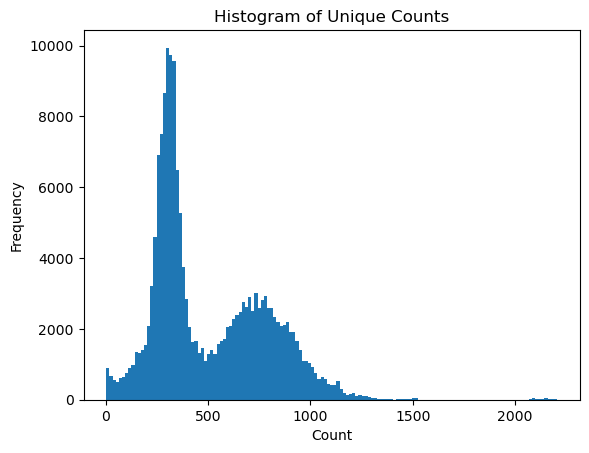

In [3]:
all_counts = []

with open('counts.txt', 'r') as f:
    lines = f.readlines()

for line in lines:
    # Load the data from the line
    unique_counts = np.fromstring(line, dtype=int, sep=' ')
    # Append the unique counts from this line to the master list
    all_counts.extend(unique_counts)

# Now all_counts contains the counts from all lines, so we can plot a single histogram
plt.hist(all_counts, bins='auto')  # 'auto' chooses bin number automatically
plt.title('Histogram of Unique Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
in_path='/home/mo/Desktop/IWR/Cell_GT_Proj/red_dots'
out_path='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells_rd/'


red_dots2Cnet(in_path,out_path)

In [ ]:
# Path to the image folder
image_folder = "/home/mo/Desktop/IWR/Cell_GT_Proj/image_log/val"

# Create a new folder for the combined images
output_folder = "/home/mo/Desktop/IWR/Cell_GT_Proj/image_log/assembled_val"
os.makedirs(output_folder, exist_ok=True)

# Get a list of all image files in the folder
image_files = [filename for filename in os.listdir(image_folder) if filename.endswith(".png")]

# Process each set of corresponding images
for image_file in image_files:
    # Extract the common identifier from the image filename
    identifier = image_file.split("_gs-", 1)[1].split(".")[0]

    # Construct the filenames of the three corresponding images
    samples_file = os.path.join(image_folder, f"samples_cfg_scale_9.00_gs-{identifier}.png")
    reconstruction_file = os.path.join(image_folder, f"reconstruction_gs-{identifier}.png")
    control_file = os.path.join(image_folder, f"control_gs-{identifier}.png")

    # Open the images
    samples_image = Image.open(samples_file)
    reconstruction_image = Image.open(reconstruction_file)
    control_image = Image.open(control_file)

    # Resize the images by half
    new_size = (samples_image.width // 4, samples_image.height // 4)
    samples_image = samples_image.resize(new_size)
    reconstruction_image = reconstruction_image.resize(new_size)
    control_image = control_image.resize(new_size)

    # Create a new image with the combined images
    combined_image = Image.new("RGB", (new_size[0], new_size[1] * 2))
    combined_image.paste(samples_image, (0, 0))
    #combined_image.paste(reconstruction_image, (0, new_size[1]))
    combined_image.paste(control_image, (0, new_size[1]))

    # Save the combined image in the output folder
    output_file = os.path.join(output_folder, f"combined_{identifier}.png")
    combined_image.save(output_file)

    # Print the saved file path
    print(f"Combined image saved: {output_file}")